## Data Preprocessing

#### Define file paths

In [1]:
folder_path = "./dataset/" #change this to your dataset folder
main_path = folder_path + "main/"
train_path = folder_path + "train/"
test_path = folder_path + "test/"
train_chars_path = folder_path + "train_chars/"
test_chars_path = folder_path + "test_chars/"

#### Define Processing Functions

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

IMG_SIZE = (64, 64)

def show(img):
    plt.imshow(img)
    plt.show()

def remove_lines(img):
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([50, 50, 50])  # Adjust as needed based on line intensity
    mask = cv2.inRange(img, lower_black, upper_black)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_inpainted = cv2.inpaint(gray, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return img_inpainted

def crop(img):
    _, thresh = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY_INV) 
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    cropped_image = img[y:y+h, x:x+w]
    return cropped_image

def segment_one(img, filename):
    captcha_contents = filename.split('-')[0]
    chars = list(captcha_contents)
    height, width = img.shape
    num_portions = len(chars)
    portion_width = width // num_portions

    segments = []

    for i in range(num_portions):
        # Segment
        x_start = i * portion_width
        x_end = x_start + portion_width
        portion = img[:, x_start:x_end]

        # Resize (keras will do it for us)
        portion = cv2.resize(portion, IMG_SIZE, interpolation=cv2.INTER_AREA)
        # Threshold the image to make sure everything is black and white
        _, portion = cv2.threshold(portion, 240, 255, cv2.THRESH_BINARY_INV)

        segments.append(portion)

    return segments

#  takes an img, returns all external contours of each letter (hopefully)
def normal_contour(img):
    binary_image  = cv2.bitwise_not(cv2.inRange(img, 254, 255))

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])

    normal_contour = []
    # Check if any contours were found
    if contours:
        # Loop through each contour and create a separate image for each one
        for i, contour in enumerate(contours):
            normal_contour.append(contour)
    return normal_contour

def extract_contour_portion(img, contour):
    contour_img = []
    contours_final = sorted(contour, key=lambda c: cv2.boundingRect(c)[0])
    for contour in contours_final:
        single_contour_image = np.zeros_like(img, dtype=np.uint8) #img is the full img
        cv2.drawContours(single_contour_image, [contour], -1, (255), thickness=cv2.FILLED)  # Use white for the contour
        contour_img.append(single_contour_image)
    images = []
    for contour in contour_img:
        # Get the rectangle that contains the contour
        masked_image = cv2.bitwise_and(img, img, mask=contour)
        (x, y, w, h) = cv2.boundingRect(contour)
        letter_image = masked_image[y :y + h, x:x + w]
        letter_image[letter_image == 0] = 255
        
        letter_image  = cv2.bitwise_not(cv2.inRange(letter_image, 254, 255))
        images.append(letter_image)
    return images


def segment_save(img, filename, destination_path):
    captcha_contents = filename.split('-')[0]
    chars = list(captcha_contents)
    for char in chars:
        class_path = os.path.join(destination_path, char)
        if not os.path.exists(class_path):
            os.makedirs(class_path)
    height, width = img.shape
    num_portions = len(chars)
    portion_width = width // num_portions

    for i in range(num_portions):
        # Segment
        x_start = i * portion_width
        x_end = x_start + portion_width
        portion = img[:, x_start:x_end]

        # Resize (keras will do it for us)
        portion = cv2.resize(portion, IMG_SIZE, interpolation=cv2.INTER_AREA)

        # Threshold the image to make sure everything is black and white
        _, portion = cv2.threshold(portion, 240, 255, cv2.THRESH_BINARY_INV)

        # Save
        char_filename = f"{chars[i]}/{chars[i]}_0.png"
        char_filepath = os.path.join(destination_path, char_filename)
        counter = 0
        while os.path.exists(char_filepath):
            char_filename = f"{chars[i]}/{chars[i]}_{counter}.png"
            char_filepath = os.path.join(destination_path, char_filename)
            counter += 1
        cv2.imwrite(char_filepath, portion)

def print_char_stats(chars_path):
    classes = os.listdir(chars_path)

    # Initialize a counter to track the occurrences of each character
    character_counter = Counter()

    # Loop through each file in the folder
    for folder in classes:
        for char in folder:
            # Make sure the file is a valid image
            if char.endswith('.png'):
                # Extract the character label from the filename (assuming filename format like 'a_1.png')
                character_label = char.split('_')[0]  # Adjust based on your filename format

                # Update the counter with the extracted character label
                character_counter[character_label] += 1

    # Total number of characters (images)
    total_characters = sum(character_counter.values())

    # Number of unique classes (characters)
    num_classes = len(classes)

    # Print statistics
    print(f"Total number of characters: {total_characters}")
    print(f"Number of unique classes (characters): {num_classes}")
    print("\nCharacter distribution:")
    for character, count in character_counter.items():
        print(f"Character '{character}': {count} instances")
    
    return num_classes

#### Process Data
Not necessary if data has already been previously processed and training datasets created. The following algorithm simply splits the image into equal portions to obtain each letter.

In [ ]:
# # Segment captchas in training data and save to folder
# if not os.path.exists(train_chars_path):
#     os.makedirs(train_chars_path)

# data_files = os.listdir(train_path)
    
# for filename in data_files:
#     img = cv2.imread(os.path.join(train_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, train_chars_path)

# # Print Stats
# num_classes = print_char_stats(train_chars_path)

# # Segment captchas in test data and save to folder
# if not os.path.exists(test_chars_path):
#     os.makedirs(test_chars_path)

# data_files = os.listdir(test_path)
    
# for filename in data_files:
#     img = cv2.imread(os.path.join(test_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, test_chars_path)

## Create and Train Model

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Initialize Data

In [4]:
train_data = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # fill_mode='nearest',
    # width_shift_range=0.2, 
    # height_shift_range=0.2,
    # zoom_range=0.3
)

test_data = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

batch_size = 32

train_generator = train_data.flow_from_directory(
    train_chars_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = test_data.flow_from_directory(
    test_chars_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 70702 images belonging to 36 classes.
Found 12010 images belonging to 36 classes.


### Define Model Save Paths

In [5]:
checkpoint_dir = "checkpoints-7L-64"
model_save_name = 'captcha-model-7L-64.keras'
history_save_path = '7L-large_history.json'

### Define Model

In [6]:
num_classes = 36
input_shape = (64, 64, 1)
model = Sequential([
    
    # 1st Conv Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
    BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    # 2nd Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    # 3rd Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 4th Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 5th Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 6th Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 7th Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    # Fully Connected Block
    Flatten(),

    Dense(512),
    LeakyReLU(alpha=0.25),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128),
    LeakyReLU(alpha=0.25),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Show model summary
model.summary()

/Users/asher/Desktop/y4s1/cs4243/CS4243-Mini-Project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/asher/Desktop/y4s1/cs4243/CS4243-Mini-Project/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 32)     │           12

 Total params: 1,308,484 (4.99 MB)

 Trainable params: 1,306,436 (4.98 MB)

 Non-trainable params: 2,048 (8.00 KB)

### Define Callbacks

In [7]:
# Early stopping callback to stop when performance plateaus
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

# Custom checkpoint class that saves weights every n epochs
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

class NFrequencyCheckpoint(ModelCheckpoint):
    def __init__(self, n, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n = n  # Frequency for saving checkpoints

    def on_epoch_end(self, epoch, logs=None):
        # Only save the checkpoint every n epochs
        if (epoch + 1) % self.n == 0:
            super().on_epoch_end(epoch, logs)

checkpoint_callback = NFrequencyCheckpoint(
    n=5,  # Save every 5 epochs
    filepath=checkpoint_dir + "/epoch-{epoch:02d}-val_loss-{val_loss:.2f}.weights.h5",
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

### Train Model


In [ ]:
epochs = 100
history = model.fit(
    train_generator, 
    epochs=epochs, 
    validation_data=test_generator,
    callbacks=[checkpoint_callback, early_stopping],
)
model.save(model_save_name)
print("model saved!")

## Evaluation

### Basic Evaluation

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

# Load model if required
from tensorflow.keras.models import load_model
model = load_model('./captcha-model-7L-large.keras')

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy']
)

# Evaluate on test data
test_loss, test_precision, test_recall, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.8170 - loss: 0.6858 - precision_1: 0.8737 - recall_1: 0.7858
Test Accuracy: 81.63%
Precision: 0.8745
Recall: 0.7857


### Save History

In [ ]:
import json

with open(history_save_path, 'w+') as f:
    json.dump(history, f, indent=4)

### Load History and Visualize

In [ ]:
import matplotlib.pyplot as plt
import json

with open(history_save_path, 'r') as f:
    history = json.load(f)

# Plot training & validation accuracy
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

## Full Captcha Recognition



In [14]:
model_save_path = 'captcha-model-7L-large.keras'
captcha_path = 'yaavh21e-0.png'
# 'k27msq-0.png'

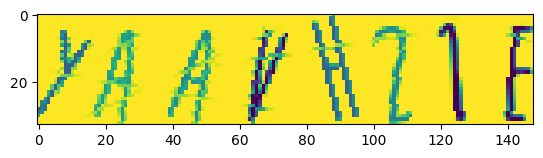

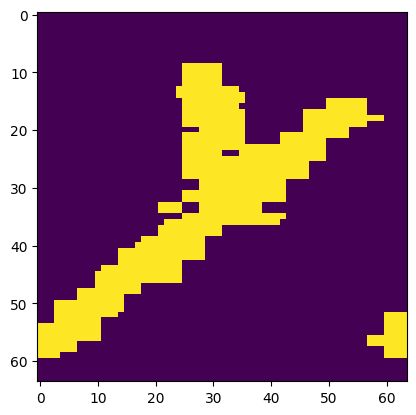

(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


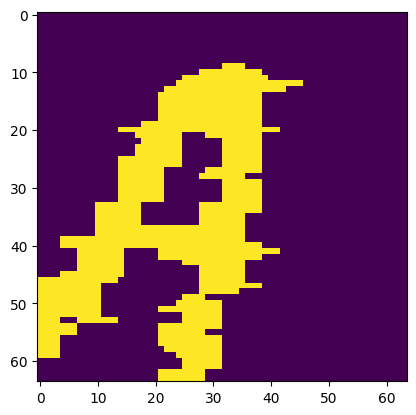

(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


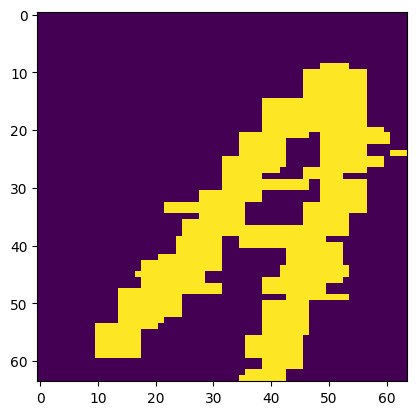

(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


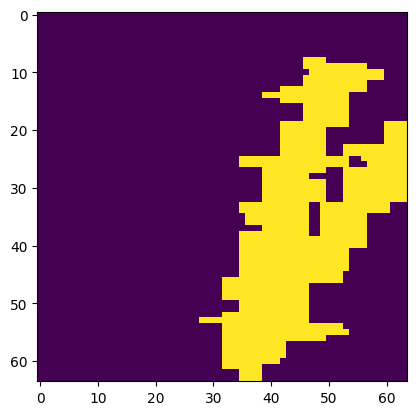

(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


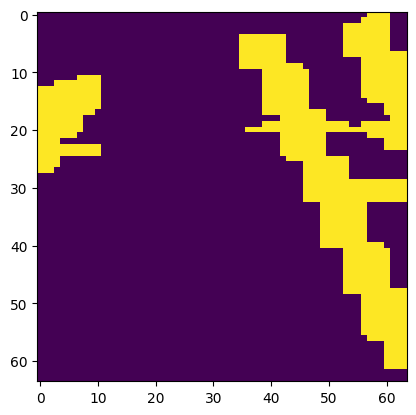

(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


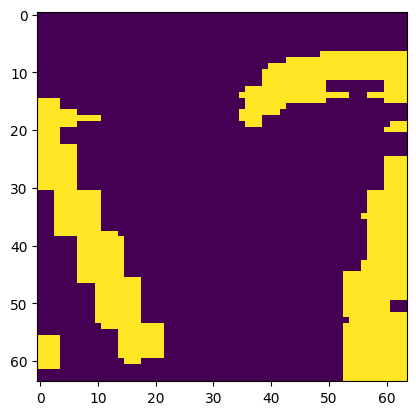

(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


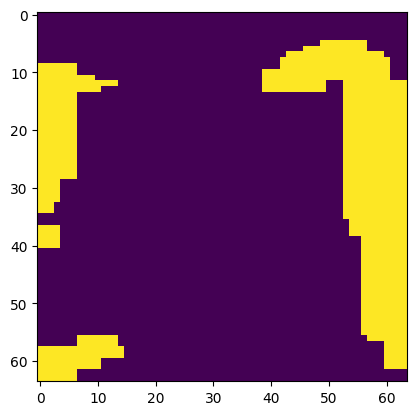

(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


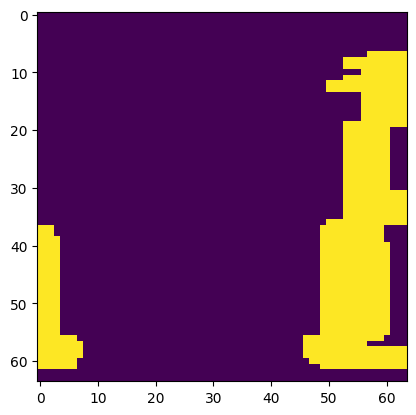

(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
yaavb21e


In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Define Class Labels
class_labels = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10:"a",
    11:"b",
    12:"c",
    13:"d",
    14:"e",
    15:"f",
    16:"g",
    17:"h",
    18:"i",
    19:"j",
    20:"k",
    21:"l",
    22:"m",
    23:"n",
    24:"o",
    25:"p",
    26:"q",
    27:"r",
    28:"s",
    29:"t",
    30:"u",
    31:"v",
    32:"w",
    33:"x",
    34:"y",
    35:"z"
}

# Load the model
model = load_model(model_save_path)

# Get captcha
filename = captcha_path
captcha = cv2.imread(os.path.join(test_path, filename))
captcha =  remove_lines(captcha)
captcha = crop(captcha)
show(captcha)
segments = segment_one(captcha, filename=filename)
contours = normal_contour(captcha)

# Contour method that works poorly but is what should be used in practice
# imgs = extract_contour_portion(captcha, contours)

# Naive split works only when number of characters are known
imgs = segments

captcha_prediction = ''
for img in imgs:
    show(img)
    img = cv2.resize(img, (64,64))
    img = image.img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    print(img.shape)
    classes = model.predict(img)
    predicted_class = np.argmax(classes)
    predicted_label = class_labels[predicted_class]
    captcha_prediction += predicted_label

print(captcha_prediction)
